In [22]:
import sklearn
import sklearn.gaussian_process
reload(sklearn.gaussian_process)
sklearn.__file__

'/Users/davidcottrell/dev/scikit-learn.git/sklearn/__init__.py'

In [23]:
def load_data():
    import sklearn.datasets as datasets
    d = datasets.load_iris()
    c = pandas.Categorical.from_codes(d.target, d.target_names)
    df = pandas.DataFrame(d.data, columns=d.feature_names)
    df['name'] = c
    df = df.sort_index(axis=1)
    dfd = pandas.get_dummies(df)
    return df, dfd

df, dfd = load_data()
print(dfd.shape)
dfd.head()

(150, 7)


,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),name_setosa,name_versicolor,name_virginica
0,1.4,0.2,5.1,3.5,1,0,0
1,1.4,0.2,4.9,3.0,1,0,0
2,1.3,0.2,4.7,3.2,1,0,0
3,1.5,0.2,4.6,3.1,1,0,0
4,1.4,0.2,5.0,3.6,1,0,0


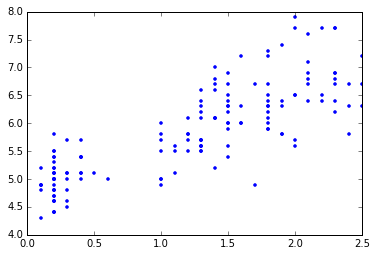

In [24]:
%matplotlib inline
kx = dfd.columns[1]
ky = dfd.columns[2]
x = df[kx].values
X = np.atleast_2d(x).T
y = df[ky].values
plot(x, y, '.')
show()

# GP

In [61]:
import numpy as np

class GP:
    """ (n, d)-array xtrain and an n-vector ytrain """
    def __init__(self, kernel, sigma=1.0):
        self.kernel = kernel
        self.sigma = sigma
        self.predict = self.posterior
        self.fit = self.add_data
        
    def add_data(self, xtrain, ytrain):
        """ append data, update mu and K """
        self.xtrain = xtrain # hstack(self.xtrain, xtrain)
        self.ytrain = ytrain # hstack(self.ytrain, ytrain)
        self.K = self.kernel(self.xtrain, self.xtrain)
        self.Ky = self.K + self.sigma ** 2 * eye(self.K.shape[0])
        
    def posterior(self, xtest):
        """ compute mu_star, K_star, sigma_star """
        Ks = self.kernel(self.xtrain, xtest)
        Kss = self.kernel(xtest, xtest)
        
        Kyinv = inv(self.Ky)
        KKyT = dot(Ks.T, Kyinv)
        
        mu = dot(KKyT, self.ytrain)
        Ss = Kss - dot(KKyT, Ks) 
        return mu, Ss
    
myGP = GP
    
import scipy.spatial.distance as dist

def sqexp_kernel(x1, x2, ell=.5, sf2=1.0):
    """ x1 and x2 of size (n, d) and (m, d) """
    d = dist.cdist(x1, x2, 'sqeuclidean')
    k = sf2 * exp(-0.5 * d / ell)
    return k

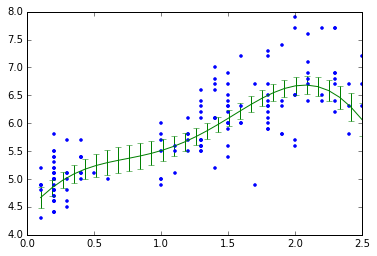

In [60]:
gp = GP(sqexp_kernel, sigma=1)
gp.add_data(X, y)
xx = np.atleast_2d(linspace(x.min(), x.max(), 30)).T
yy = np.atleast_2d(linspace(y.min(), y.max(), 30)).T
yp, s2 = gp.posterior(xx)

plot(x, y, '.')
errorbar(xx.squeeze(), yp, yerr=np.sqrt(np.diag(s2)))
show()

/Users/davidcottrell/dev/scikit-learn.git/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess is deprecated and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/davidcottrell/dev/scikit-learn.git/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances is deprecated and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


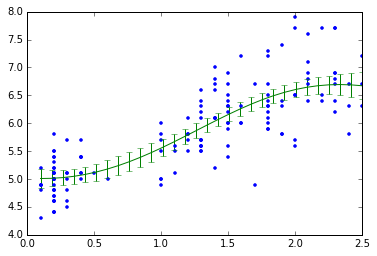

In [58]:
import sklearn.gaussian_process as gaussian_process

GP = gaussian_process.GaussianProcess(corr='squared_exponential', nugget=2, theta0=0.01, thetaL=1e-4, thetaU=0.5)

GP.fit(X, y)

ypb, s2b = GP.predict(xx, eval_MSE=True)

plot(x, y, '.')
errorbar(xx.squeeze(), ypb, yerr=1.96 * np.sqrt(s2b))
show()

# RF

<Container object of 3 artists>

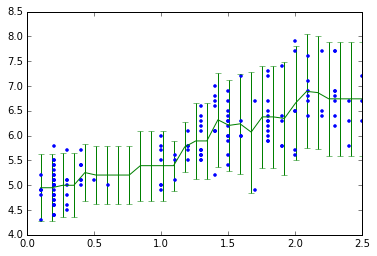

In [32]:
import sklearn.ensemble as se

def trainmodel(estimator_mean, estimator_var, X, y):
    i = 0
    e = estimator_mean
    e2 = estimator_var
    sample_weights = None; ss=None
    while i<3:
        e.fit(X, y, sample_weight=sample_weights)
        yp = e.predict(X)
        yy = (y - yp) ** 2
        e2.fit(X, yy, sample_weight=None)
        yyp = e.predict(X)
        sample_weights = 1 / np.sqrt(yyp)
        ss = 1 / sample_weights
        i = i + 1
    return e, e2

params = dict(n_estimators=100, min_samples_leaf=10)
params2 = params.copy()
params2['min_samples_leaf'] = 30
e = se.GradientBoostingRegressor(**params)
e2 = se.GradientBoostingRegressor(**params2)
trainmodel(e, e2, X, y)
yp = e.predict(xx)
yyp = e2.predict(xx)
plot(X[:,0], y, '.')
errorbar(xx[:,0], yp, yerr=1.96 * np.sqrt(yyp))

# GMM

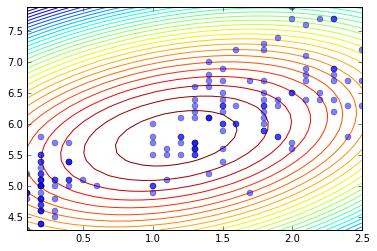

In [127]:
import sklearn.mixture as sm
e = sm.DPGMM(n_components=10, covariance_type='full')
A = np.concatenate([X, np.atleast_2d(y).T], axis=1)
e.fit(A)

XX, YY = meshgrid(xx, yy)
XY = np.vstack([XX.ravel(), YY.ravel()]).T
PP = e.score(XY)
PP = PP.reshape(-1, 30)

plot(X.squeeze(), y.squeeze(), 'o', alpha=0.5)
contour(XX, YY, PP, 30)